## Identifying cell types in scRNA-seq data

### Students notebook

Here we are, the final exercise of this course. We will now check whether we can replicate the same calssification provided in the original publication for the cells we selected. As we saw in the coding lecture, cell type identification usually includes at least three steps:
- clustering cells in distinct groups according to their transcriptomic profile
- identifying the marker genes characterizing each cluster
- assign each cluster to a cell type according to their respective markers

First, let's read the data and import the relevant packages

In [1]:
# loading packages
import numpy as np
import pandas as pd
import scanpy as sc

# loading the preprocessed
scderp = sc.read_h5ad('./data/scderp.h5ad')

# little unknown bug in scanpy!
scderp.uns['log1p'] = {'base':None}

The first step, cell clustering, is performed through three different scanpy functions:
- `tl.pca`, which computes the principal components in the transcriptomics space
- `pp.neighbors`, which identifies for each cell a subset of other cells with very similar transcriptomics profile
- `tl.leiden`, which applied the "leiden" algorithm for grouping together similar cells

Let's apply these functions on our data!

In [2]:
# Exercise: apply the following functions in order, using the suggested settings
# tl.pca, with svd_solver='arpack'
# pp.neighbor, with n_neighbors=10, and n_pcs=30
# tl.leiden

# your code here
sc.tl.pca(scderp, svd_solver='arpack')
sc.pp.neighbors(scderp, n_neighbors=10, n_pcs=30)
sc.tl.leiden(scderp)
# the clusters should be recorded in the 'leiden' column of the obs data frame
scderp.obs['leiden']

1      0
2      2
3      6
5      1
6      1
      ..
495    4
496    4
497    5
498    4
499    2
Name: leiden, Length: 380, dtype: category
Categories (8, object): [0, 1, 2, 3, 4, 5, 6, 7]

In [ ]:
# tip: this is the same pipeline we saw in the coding lectures


The cells are now grouped in different clusters, as recorded in the `leiden` coolumn of the `obs` data frame. Let's visualize them with a UMAP.

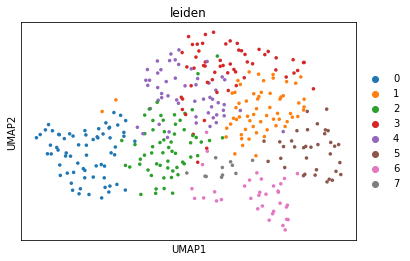

In [3]:
# computing the UMAP
sc.tl.umap(scderp)

# visualizing the UMAP
sc.pl.umap(scderp, color = 'leiden', size=50)

With respect to the UMAP we saw in the coding lecture, this is much more sparse, due to the lower number of cells depicted in it. 

We can now pass to the second step, the identification of marker genes for each cluster.

In [4]:
# exercise: find the differentially expressed genes characterizing each cluster

# your code here
sc.tl.rank_genes_groups(scderp, groupby='leiden', method='t-test')

In [ ]:
# tip: use the tl.rank_genes_groups function (method = 't-test')


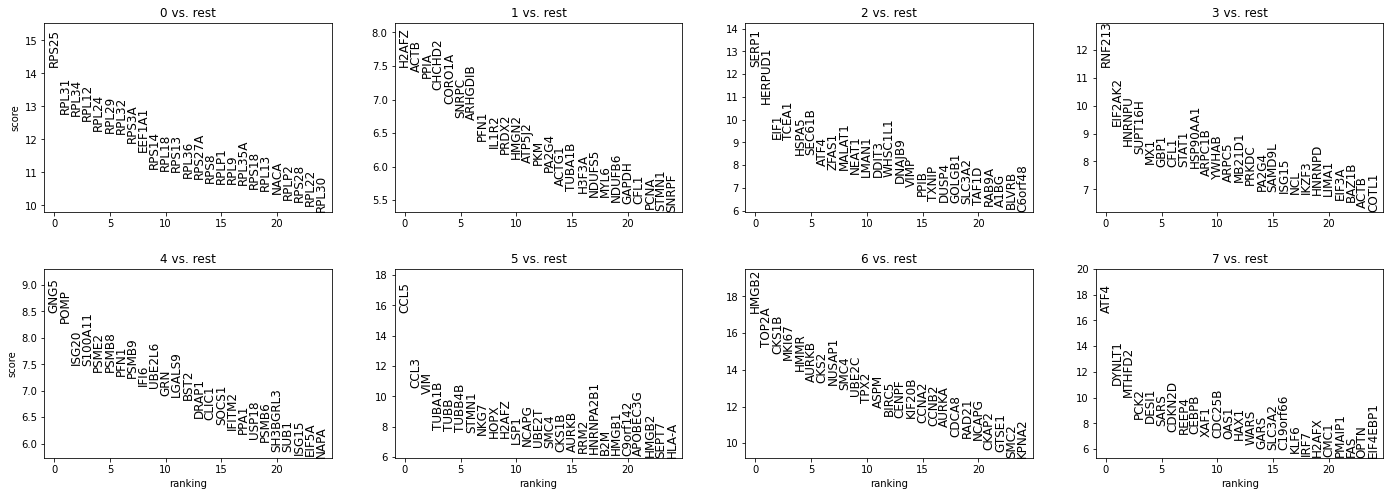

In [5]:
# for each cluster, plot the 25 most differentially expressed genes
sc.pl.rank_genes_groups(scderp, n_genes=25, sharey=False, fontsize=12)

It is now time for the last step of the analysis: assigning each cluster to a cell type. This is not trivial, and you may already notice that it is not immediately possile to trace the markers below in the list of differentially expressed genes reported above.

 Markers | Cell Type
 ---|---
 LRRN3, CCR7, SELL | Naive T-cells (TN)
 PASK | Central Memory T-cells (TCM)
 IL7R, KLRB1, TNFSF13B | Effector Memory T-cells (TEM) 
 CCL4, GZMH, GZMA, GNLY, NKG7, CST7 | Effector Memory T-cells re-expressing CD45RA (TEMRA)

For the next exercise, let's use the tl.marker_gene_overlap function. Have a look to the documentation, particularly to the examples: https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.marker_gene_overlap.html

In [6]:
# let's organize the marker genes in a dictionary
marker_genes = {
    'TN': {'LRRN3', 'CCR7', 'SELL'},
    'TCM': {'PASK'},
    'TEM': {'IL7R', 'KLRB1', 'TNFSF13B'},
    'TEMRA': {'CCL4', 'GZMH', 'GZMA', 'GNLY', 'NKG7', 'CST7'}
}

# exercise: use the tl.marker_gene_overlap function for assigning the cluster identities
# store the results of the tl.marker_gene_overlap function in the markers_matches variable
# use top_n_markers=300 as additional argument
markers_matches = sc.tl.marker_gene_overlap(scderp, marker_genes, top_n_markers=300)

# your code here


print(markers_matches)

         0    1    2    3    4    5    6    7
TN     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
TCM    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
TEM    1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
TEMRA  0.0  0.0  0.0  0.0  0.0  6.0  0.0  0.0


In [ ]:
# tip: read the tl.marker_gene_overlap documentation online if you need additional guidance!


You should have obtained a matrix where higher positive numbers indicate that clusters (columns) can be assigned to a specific cell type (rows). We can see that cluster 5 is probably formed by TEMRA cells, while cluster 0 and 4 by TEM cells. No cluster was assigned to TCM or TN, and no cell type was found for clusters 1, 2, 3, 6, and 7. This may be due to the low amount of cells used in this exercise, or to the effect of the cytokines.